<a href="https://colab.research.google.com/github/colaprograms/2019-hackathon-ocr-wymbah/blob/master/notebooks/ctc_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, torch, re, sys
import numpy as np
import matplotlib.pyplot as p
import random, PIL

In [3]:
os.chdir("/content")
if not os.path.exists("/content/AI4Good---Meza-OCR-Challenge"):
  !git clone https://github.com/Charitable-Analytics-International/AI4Good---Meza-OCR-Challenge
if not os.path.exists("/content/2019-hackathon-ocr-wymbah"):
  !git clone https://github.com/colaprograms/2019-hackathon-ocr-wymbah
os.chdir("/content/2019-hackathon-ocr-wymbah")
!git pull

from importlib import reload
import util.file
reload(util.file)

Already up to date.
Using path /content/AI4Good---Meza-OCR-Challenge
Using path /content/AI4Good---Meza-OCR-Challenge


<module 'util.file' from '/content/2019-hackathon-ocr-wymbah/util/file.py'>

9,700


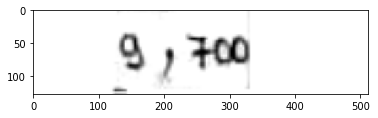

torch.Size([20, 3, 128, 512])

In [25]:
from util.file import FileHolder
fh = FileHolder()
inp, outp = fh.get_batch(1)

for file, val in zip(inp, outp):
  print(val)
  p.imshow(file)
  p.show()

def to_tensor(buf):
  buf = 2*buf - 1
  return torch.tensor(buf, dtype=torch.float32).permute(0, 3, 1, 2)

def get_batch(batchsize, validation=False):
  inp, outp = fh.get_batch(batchsize, validation)
  inp = np.stack(inp)
  inp = to_tensor(inp)
  return inp, outp

get_batch(20)[0].shape

In [0]:
import torch.nn as nn
import torch.optim as optim
import torchvision



In [43]:
chars = " 0123456789-,."
nchars = len(chars)
idx = {}
for i, c in enumerate(chars): idx[c] = i

ntraining = len(fh.info['training'])

BATCH_SIZE = 16

def maketarget(outputs):
  classes = [torch.tensor([idx[c] for c in string], dtype=torch.long) for string in outputs]
  lengths = [len(string) for string in outputs]
  return nn.utils.rnn.pack_sequence(classes, enforce_sorted=False), lengths

trainloss = []
validloss = []
def run():
  resnet = torchvision.models.resnet.resnet34(True)

  "Cut off the last two layers"
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    return x

  import types
  resnet.forward = types.MethodType(forward, resnet)
  resnet = resnet.cuda()
  for param in resnet.parameters():
    param.requires_grad = False
  lstm = nn.LSTM(512, 128, dropout=0.1, bidirectional=True).cuda()
  layernorm1 = nn.LayerNorm((256,)).cuda()
  dense1 = nn.Linear(256, 256).cuda()
  layernorm2 = nn.LayerNorm((256,)).cuda()
  dense2 = nn.Linear(256, nchars).cuda()
  def params():
    yield from lstm.parameters()
    yield from dense1.parameters()
    yield from dense2.parameters()
  avgpool = nn.AdaptiveAvgPool2d((1, 16)).cuda()
  ctc = nn.CTCLoss(reduction='none').cuda()
  
  optimizer = optim.SGD(params(), lr=0.001, momentum=0.9)

  def crunch(inp, outp):
    inp = resnet(inp.cuda())
    inp = avgpool(inp)
    inp = inp.reshape([-1, 512, 16]).permute(0, 2, 1)
    inp, _ = lstm(inp)
    inp = layernorm1(inp)
    inp = dense1(inp)
    inp = layernorm2(inp)
    inp = dense2(inp)
    inp = nn.functional.log_softmax(inp, dim=2)
    input_lengths = [16 for i in range(inp.shape[0])]
    target, target_lengths = maketarget(outp)
    input_lengths, target_lengths = map(tuple, [input_lengths, target_lengths])
    loss = ctc(inp, target.data.cuda(), input_lengths, target_lengths)
    return loss.mean()
  for epoch in range(999999):
    running_loss = 0.0
    length = 0
    for i in range(200):
      inp, outp = get_batch(BATCH_SIZE)
      optimizer.zero_grad()
      loss = crunch(inp, outp)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      length += BATCH_SIZE
    trainingloss = running_loss / length
    print("Epoch %d. Loss: %f" % (epoch, trainingloss))
    trainloss.append(trainingloss)
    running_loss = 0.0
    length = 0
    for i in range(20):
      inp, outp = get_batch(BATCH_SIZE, validation=True)
      loss = crunch(inp, outp)
      running_loss += loss.item()
      length += BATCH_SIZE
    validationloss = running_loss / length
    print("Validation loss: %f" % validationloss)
    validloss.append(validationloss)
    file = "checkpoint-%04d-%.2f" % (epoch, validationloss)
    torch.save({
        'lstm': lstm.state_dict(),
        'dense1': dense1.state_dict(),
        'dense2': dense2.state_dict(),
        'epoch': epoch
    }, file)
    print("Saved", file)

run()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0. Loss: 0.544250
Validation loss: 0.501702
Saved checkpoint-0000-0.50
Epoch 1. Loss: 0.503433
Validation loss: 0.493178
Saved checkpoint-0001-0.49
Epoch 2. Loss: 0.493248
Validation loss: 0.497423
Saved checkpoint-0002-0.50
Epoch 3. Loss: 0.498054
Validation loss: 0.526267
Saved checkpoint-0003-0.53
Epoch 4. Loss: 0.498963
Validation loss: 0.482861
Saved checkpoint-0004-0.48
Epoch 5. Loss: 0.493591
Validation loss: 0.521288
Saved checkpoint-0005-0.52
Epoch 6. Loss: 0.490283
Validation loss: 0.494549
Saved checkpoint-0006-0.49


KeyboardInterrupt: ignored

In [226]:
image_tensor = torch.Tensor(image)
image_tensor = torch.unsqueeze(image_tensor, 0)
image_tensor = image_tensor.permute(0, 3, 1, 2)
out = resnet(image_tensor)
print(out)
print(out.shape)

tensor([[[[0.0000e+00, 8.4632e-03, 4.4118e-01,  ..., 3.5947e-01,
           0.0000e+00, 0.0000e+00],
          [1.5710e+00, 1.6492e+00, 4.3799e-01,  ..., 1.9591e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.5652e+00,
           1.0369e-01, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 2.7234e-01,  ..., 4.7540e+00,
           1.5719e+00, 0.0000e+00]],

         [[8.1148e-01, 6.8881e-01, 1.4770e+00,  ..., 2.5300e+00,
           2.8111e-01, 0.0000e+00],
          [0.0000e+00, 1.1480e-01, 1.6761e+00,  ..., 3.0082e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 3.6867e-01,  ..., 6.7188e-02,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 7.3576e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6493e-01,
           6.6963e-01,